# Entrenando un primer modelo

## Índice de Contenido

1. [Carga de datos en formato numérico](#1.-Carga-de-datos-en-formato-numérico)
2. [Preparación de datos para el entrenamiento](#2.-Preparación-de-datos-para-el-entrenamiento)
3. [Entrenamiento del modelo de regresión logística](#3.-Entrenamiento-del-modelo-de-regresión-logística)
4. [Evaluación del modelo mediante métricas de clasificación](#4.-Evaluación-del-modelo-mediante-métricas-de-clasificación)
5. [Análisis de la matriz de confusión](#5.-Análisis-de-la-matriz-de-confusión)
6. [Preparación de datos para análisis de equidad](#6.-Preparación-de-datos-para-análisis-de-equidad)
7. [Resumen y conclusiones](#7.-Resumen-y-conclusiones)

## 1. Carga de datos en formato numérico

En lugar de utilizar los datos transformados en el notebook de preprocesamiento,
cargaremos un conjunto de datos numérico que se encuentra en la fuente original.
Este conjunto contiene las mismas variables pero en formato numérico, facilitando
el entrenamiento de modelos predictivos.

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

ruta_archivo = os.path.join('..', 'data', 'processed', 'german_credit_data.csv')

g_credit_data_numeric = pd.read_csv(ruta_archivo)

print(f"Dimensiones del dataset numérico: {g_credit_data_numeric.shape}")
print("\nPrimeras 5 filas del dataset numérico: ")
display(g_credit_data_numeric.head())

Dimensiones del dataset numérico: (1000, 23)

Primeras 5 filas del dataset numérico: 


,checking_account,duration,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status_sex,other_debtors,...,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,target,genre,target_label
0,< 0 DM,6,critical account / other bank,radio/TV,1169,unknown / no account,>= 7 years,4,"male, single",none,...,none,own,2,skilled / official,1,"yes, registered",yes,1,male,low_risk
1,0 <= ... < 200 DM,48,paid duly till now,radio/TV,5951,< 100 DM,1 <= ... < 4 years,2,"female, div/sep/married",none,...,none,own,1,skilled / official,1,none,yes,2,female,high_risk
2,no account,12,critical account / other bank,education,2096,< 100 DM,4 <= ... < 7 years,2,"male, single",none,...,none,own,1,unskilled - resident,2,none,yes,1,male,low_risk
3,< 0 DM,42,paid duly till now,furniture/equipment,7882,< 100 DM,4 <= ... < 7 years,2,"male, single",guarantor,...,none,for free,1,skilled / official,2,none,yes,1,male,low_risk
4,< 0 DM,24,delay in past,car (new),4870,< 100 DM,1 <= ... < 4 years,3,"male, single",none,...,none,for free,2,skilled / official,2,none,yes,2,male,high_risk


### 1.1 Limpieza de datos

In [71]:
g_credit_data_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   checking_account         1000 non-null   object
 1   duration                 1000 non-null   int64 
 2   credit_history           1000 non-null   object
 3   purpose                  1000 non-null   object
 4   credit_amount            1000 non-null   int64 
 5   savings_account          1000 non-null   object
 6   employment_since         1000 non-null   object
 7   installment_rate         1000 non-null   int64 
 8   personal_status_sex      1000 non-null   object
 9   other_debtors            1000 non-null   object
 10  residence_since          1000 non-null   int64 
 11  property                 1000 non-null   object
 12  age                      1000 non-null   int64 
 13  other_installment_plans  1000 non-null   object
 14  housing                  1000 non-null   

## 2. Preparación de datos para el entrenamiento

Prepararemos los datos para el entrenamiento de nuestro modelo de regresión logística.
Esto implica:
1. Separar variables predictoras (X) de la variable objetivo (y)
2. Transformar la variable objetivo a formato binario (0 para bajo riesgo, 1 para alto riesgo)
3. Dividir los datos en conjuntos de entrenamiento y prueba
4. Preparar la matriz de diseño con término de intercepto para la regresión logística

In [72]:
# Convertimos todas las columnas categóricas a variables dummy
g_credit_data_dummies = pd.get_dummies(g_credit_data_numeric, drop_first=True)

g_credit_data_dummies['target_label_high_risk'] = g_credit_data_dummies['target'] == 2

g_credit_data_dummies.drop(columns=['target'], inplace=True)
g_credit_data_dummies.drop(columns=['target_label_low_risk'], inplace=True)

# Convertimos las variables categóricas a enteros
g_credit_data_dummies = g_credit_data_dummies.astype(int)

print("Primeras filas del DataFrame convertido a dummies:")
display(g_credit_data_dummies.head())

Primeras filas del DataFrame convertido a dummies:


,duration,credit_amount,installment_rate,residence_since,age,number_credits,people_liable,checking_account_< 0 DM,checking_account_>= 200 DM or salary assigned,checking_account_no account,...,other_installment_plans_stores,housing_own,housing_rent,job_skilled / official,job_unemployed / non-resident,job_unskilled - resident,"telephone_yes, registered",foreign_worker_yes,genre_male,target_label_high_risk
0,6,1169,4,4,67,2,1,1,0,0,...,0,1,0,1,0,0,1,1,1,0
1,48,5951,2,2,22,1,1,0,0,0,...,0,1,0,1,0,0,0,1,0,1
2,12,2096,2,3,49,1,2,0,0,1,...,0,1,0,0,0,1,0,1,1,0
3,42,7882,2,4,45,1,2,1,0,0,...,0,0,0,1,0,0,0,1,1,0
4,24,4870,3,4,53,2,2,1,0,0,...,0,0,0,1,0,0,0,1,1,1


In [73]:
# Separamos variables predictoras (X) y variable objetivo (y)
X = g_credit_data_dummies.iloc[:, :-1]
y = g_credit_data_dummies.iloc[:, -1]
indices = X.index

# Dividimos en conjuntos de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X.values, y.values, indices, test_size=0.2, random_state=42
)

# Agregamos columna de intercepto (unos) a las matrices de diseño
X_train_design = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test_design = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

print(f"Dimensiones de X_train_design: {X_train_design.shape}")
print(f"Dimensiones de X_test_design: {X_test_design.shape}")
print(f"Distribución de clases en el conjunto de entrenamiento: {np.bincount(y_train)}")
print(f"Distribución de clases en el conjunto de prueba: {np.bincount(y_test)}")

Dimensiones de X_train_design: (800, 50)
Dimensiones de X_test_design: (200, 50)
Distribución de clases en el conjunto de entrenamiento: [559 241]
Distribución de clases en el conjunto de prueba: [141  59]


## 3. Entrenamiento del modelo de regresión logística

Utilizaremos un modelo de regresión logística como nuestro primer enfoque debido a:

1. **Simplicidad e interpretabilidad**: La regresión logística es un modelo sencillo
   cuyos coeficientes pueden interpretarse directamente, facilitando el análisis de equidad.

2. **Adecuación al problema**: Al ser un problema de clasificación binaria (alto/bajo riesgo),
   la regresión logística es una opción natural y efectiva.

3. **Eficiencia computacional**: Requiere menos recursos y tiempo de entrenamiento
   que modelos más complejos, lo que es ideal para una primera iteración.

Utilizaremos funciones personalizadas de nuestro módulo de utilidades para el ajuste
y la predicción del modelo.

In [74]:
from tp_final_fairness_ML.utils.models import ajustar_regresion_logistica, predecir_regresion_logistica

coeficientes = ajustar_regresion_logistica(X_train_design, y_train)
y_pred_test = predecir_regresion_logistica(X_test_design, coeficientes)

Entrenando modelo de regresión logística...


/Users/gianni/Documents/tpfinal_equidad/tp_final_fairness_ML/utils/models.py:24: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Predicciones completadas.


## 4. Evaluación del modelo mediante métricas de clasificación

Evaluaremos el desempeño del modelo utilizando métricas estándar de clasificación:

- **Precisión (Precision)**: Proporción de predicciones positivas que fueron correctas
- **Sensibilidad (Recall)**: Proporción de casos positivos reales que fueron correctamente identificados
- **F1-Score**: Media armónica de precisión y sensibilidad
- **Exactitud (Accuracy)**: Proporción total de predicciones correctas

Estas métricas nos darán una visión general de la calidad del modelo y su capacidad
para identificar correctamente tanto solicitantes de bajo como de alto riesgo.

In [75]:
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_test))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       141
           1       0.67      0.59      0.63        59

    accuracy                           0.80       200
   macro avg       0.76      0.74      0.74       200
weighted avg       0.79      0.80      0.79       200



### Interpretación de las métricas

- **Clase 0 (Bajo riesgo)**: El modelo muestra un buen desempeño identificando solicitantes de bajo riesgo:
  - Precisión: 0.84 - El 84% de los solicitantes clasificados como bajo riesgo efectivamente lo son.
  - Sensibilidad: 0.88 - El modelo identifica correctamente el 89% de los solicitantes de bajo riesgo.
  - F1-Score: 0.86 - Buen balance entre precisión y sensibilidad para esta clase.

- **Clase 1 (Alto riesgo)**: El desempeño es menor para identificar solicitantes de alto riesgo:
  - Precisión: 0.67 - Solo el 66% de los solicitantes clasificados como alto riesgo realmente lo son.
  - Sensibilidad: 0.59 - El modelo solo identifica correctamente el 53% de los solicitantes de alto riesgo.
  - F1-Score: 0.63 - Desempeño moderado para esta clase.

- **Exactitud general**: 0.76 - El 76% de todas las predicciones son correctas.

Este desequilibrio en el desempeño entre clases podría atribuirse principalmente a la
distribución desbalanceada de las clases en los datos, donde hay más solicitantes de
bajo riesgo que de alto riesgo. Esta situación es común en problemas de crédito y
requiere atención especial desde la perspectiva de equidad.

## 5. Análisis de la matriz de confusión

La matriz de confusión nos permitirá visualizar en detalle los aciertos y errores del modelo,
así como entender los diferentes tipos de errores (falsos positivos y falsos negativos) y su
impacto en términos de equidad y toma de decisiones.

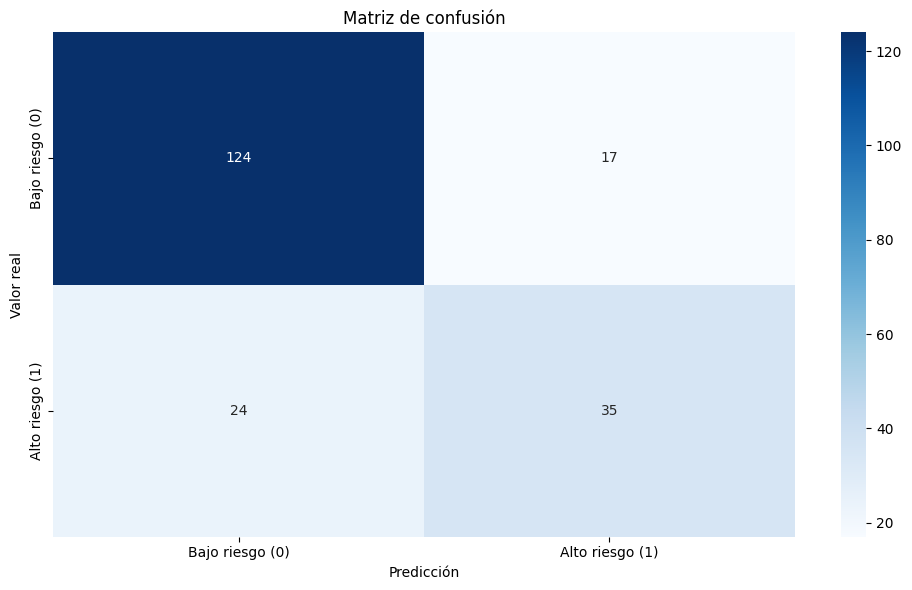

In [76]:
cm = confusion_matrix(y_test, y_pred_test)
labels = ['Bajo riesgo (0)', 'Alto riesgo (1)']

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión')
plt.tight_layout()
plt.show()

### Interpretación de la matriz de confusión

Para interpretar correctamente la matriz, consideremos:

- **Verdaderos positivos (TP)**: 124 solicitantes fueron correctamente clasificados como de bajo riesgo.
- **Falsos negativos (FN)**: 17 solicitantes de bajo riesgo fueron incorrectamente clasificados como de alto riesgo.
- **Falsos positivos (FP)**: 24 solicitantes de alto riesgo fueron incorrectamente clasificados como de bajo riesgo.
- **Verdaderos negativos (TN)**: 35 solicitantes fueron correctamente clasificados como de alto riesgo.

**Implicaciones de los errores**:

1. **Falsos positivos (24)**: Este tipo de error es particularmente problemático para instituciones financieras, ya que implica otorgar préstamos a personas que realmente son de alto riesgo, lo que podría resultar en pérdidas financieras.

2. **Falsos negativos (17)**: Aunque menos costoso desde la perspectiva financiera, este error implica negar préstamos a personas que realmente son de bajo riesgo, lo que representa un problema de equidad y acceso a servicios financieros.

El balance entre estos tipos de errores es fundamental para garantizar tanto la salud financiera de la institución como la equidad en el acceso al crédito para diferentes grupos demográficos.

## 6. Preparación de datos para análisis de equidad

Para realizar un análisis de equidad por género, necesitamos combinar nuestras predicciones
con la información de género de los solicitantes. Esto nos permitirá evaluar si el modelo
presenta sesgos algorítmicos que afecten desproporcionadamente a algún grupo.

Crearemos un nuevo conjunto de datos que contenga:
- Las etiquetas reales (y_test)
- Las predicciones del modelo (y_pred_test)
- El género de cada solicitante

In [77]:
ruta_datos_procesados = os.path.join('..', 'data', 'processed', 'german_credit_data.csv')
g_credit_data = pd.read_csv(ruta_datos_procesados)

df_genero_eval = pd.DataFrame({
    'y_test': y_test,
    'y_pred_test': y_pred_test,
    'genre': g_credit_data.loc[idx_test, 'genre']
})

print("Primeras filas del dataframe para análisis de equidad:")
display(df_genero_eval.head())

ruta_guardado = os.path.join('..', 'data', 'processed', 'df_genero_eval.csv')
df_genero_eval.to_csv(ruta_guardado, index=False)
print(f"Datos guardados en: {ruta_guardado}")

Primeras filas del dataframe para análisis de equidad:


,y_test,y_pred_test,genre
521,1,0,female
737,0,1,male
740,0,1,male
660,0,0,male
411,0,0,male


Datos guardados en: ../data/processed/df_genero_eval.csv


## 7. Resumen y conclusiones

En este notebook hemos completado las siguientes tareas:

1. **Carga y preparación de datos**: Importamos el conjunto de datos German Credit en formato numérico.

2. **Entrenamiento del modelo**: Implementamos un modelo de regresión logística para predecir el riesgo crediticio.

3. **Evaluación de desempeño**: Analizamos las métricas de clasificación y la matriz de confusión para entender el comportamiento del modelo.

4. **Preparación para análisis de equidad**: Generamos un conjunto de datos que incluye las predicciones y el género de los solicitantes.

Observamos que el modelo tiene un buen desempeño general (78% de exactitud), pero muestra diferencias significativas en su capacidad para identificar correctamente las dos clases: es mejor identificando solicitantes de bajo riesgo (89% de sensibilidad) que solicitantes de alto riesgo (53% de sensibilidad).